In [3]:
import sys
import os

# modify syspath directory to sys.path

package_path = os.path.abspath(os.path.join('..','core'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..','utils'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..'))
if package_path not in sys.path:
    sys.path.append(package_path)

import numpy as np
import qutip as qt
import math
import matplotlib.pyplot as plt
import pickle

from IPython.display import HTML # both needed to disply gifs
from PIL import Image

# Import modules from the package
from core import create_hamiltonian as ch
from core import create_state as cs
from core import create_coherent_state
from core import time_evo
from core import time_evo_new
from core import time_evo_from_state
from core import time_evo_rd_ACL
from core import load_param
from core import load_H_list
from core import load_result
from core import load_tlist
from core import operators
from core.schmidt_solve import compute_schmidt_states_all_time
from core.eigen_ener_states import eigen_ener_states as eig
from core import annihilation_operator
from utils.entropy import compute_VN, plot_VN, compute_VN_time, plot_VN_numpy
from utils import collapse_gif
from utils.collapse_gif import collapse_gif
from utils.display_gif import display_gif
from utils.distribution_gif import gif_distribution_eig_total
from utils.distribution_gif import prob_gif
from utils.distribution_gif import gif_distrib_H_s_int
from utils.distribution_gif import gif_distrib_system_first_eig
from utils.plot import plot_basic
from utils.plot import plot_with_binning
from utils.basic_functions import state_distribution_eig_tot
from utils.basic_functions import random_dephasing
from utils.basic_functions import get_state_probabilities
from utils.basic_functions import position
from utils.basic_functions import copy_cat
from utils.basic_functions import plot_einselection
from utils.overlap import overlap
from utils.overlap import gif_schmidt_overlap
from utils.interference import interference_plot
from utils.expectations import exp_val_time
from utils.plot_hamiltonians import plot_hamiltonians
from utils import locality_utils

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.titlesize'] = 16             # Title font size
plt.rcParams['axes.titleweight'] = 'bold'       # Title font weight
plt.rcParams['axes.labelsize'] = 14             # X and Y label font size
plt.rcParams['axes.labelweight'] = 'bold'       # X and Y label font weight
#plt.rcParams['axes.grid'] = True                # Enable grid
#plt.rcParams['grid.alpha'] = 0.7                # Grid transparency
#plt.rcParams['grid.linestyle'] = '--'           # Grid line style
#plt.rcParams['grid.color'] = 'gray'             # Grid color

# Tick settings
plt.rcParams['xtick.labelsize'] = 12            # X tick label size
plt.rcParams['ytick.labelsize'] = 12            # Y tick label size
plt.rcParams['xtick.direction'] = 'in'          # X tick direction
plt.rcParams['ytick.direction'] = 'in'          # Y tick direction
plt.rcParams['xtick.major.size'] = 6            # X major tick size
plt.rcParams['ytick.major.size'] = 6            # Y major tick size

# Legend settings
plt.rcParams['legend.fontsize'] = 12            # Legend font size
plt.rcParams['legend.frameon'] = True           # Enable legend frame
plt.rcParams['legend.framealpha'] = 0.9         # Legend frame transparency
plt.rcParams['legend.loc'] = 'best'             # Legend location

# Line and marker settings
plt.rcParams['lines.linewidth'] = 2             # Line width
plt.rcParams['lines.markersize'] = 6            # Marker size

custom_colors = ['#1c4587', '#e6194B', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

temp code to put in local_utils

In [84]:
#We define a function to see the overlap between environemnt states.
def plot_overlap(n_e, file_name,file_suffixes):
    """
    Calculate and plot |r(t)|^2, the overlap between two environment states.

    Parameters:
    t_list (array-like): List of time points.
    state1 (qutip.Qobj): First environment state.
    state2 (qutip.Qobj): Second environment state.
    """

    d_2=2**n_e
    identity = qt.qeye(d_2)  # Adjust dimension if needed
    #density_matrix = qt.ptrace(global_state, [0]) # Calculate the density matrix at the specified time
    # Construct the full projection operator |0><0| ⊗ I
    ket_0 = qt.basis(2, 0)  # |0>
    ket_1 = qt.basis(2, 1)  # |0>
    proj_0 = ket_0 * ket_0.dag()  # |0><0|
    proj_1 = ket_0 * ket_1.dag()  # |0><0|
    proj_op_0 = qt.tensor(proj_0, identity)
    proj_op_1 = qt.tensor(proj_1, identity)
    result_list=[]
    for suffix in file_suffixes:
        file_name_2=f"{file_name}_{suffix}"
        tmax, ind_nb, log = load_param(file_name_2)
        tlist = load_tlist(file_name_2)
        result = load_result(file_name_2)
        result_list.append(result)
    
    l=len(file_suffixes)
    o_list=[]
    for i in range(l-1):
        overlap_values=[]
        for i in range(ind_nb):
            global_state = result.states[i]
            e0=proj_op_0 * global_state
            e1=proj_op_1 * global_state
            overlap_values.append(abs(e0.overlap(e1)*np.conjugate(e1.overlap(e0))))
        o_list.append(overlap_values)

    # Plot the results
    from matplotlib import cm
    blues = cm.Blues(np.linspace(0.4, 0.8, l))  # Blue shades for the first 4 (local)

    # Plot for local Hamiltonian
    for i in range(l-1):
        plt.plot(tlist, o_list[i], color=blues[i])
    plt.plot(tlist, o_list[l-1], color=blues[l-1], label="label")
    
    plt.xlabel('Time')
    plt.ylabel(r'$|r(t)|^2$')#plt.title('Von Neumann Entropy over time')
    plt.grid(True)
    plt.legend()
    name=file_name+"r"+".pickle"
    with open(name, 'wb') as f:
        pickle.dump(plt.gcf(), f)  # Save the current figure (gcf)
    plt.show()
    
    #plt.figure(figsize=(6, 4))
    #plt.plot(t_list, overlap_values, label=r'$|r(t)|^2$', color=custom_colors[0])
    #plt.xlabel('Time')
    #plt.ylabel(r'$|r(t)|^2$')
    #plt.xscale('log')
    #plt.title('Overlap between Environment States')
    #plt.legend()
    #plt.grid(True)
    #plt.show()



Getting the general decoherence thing

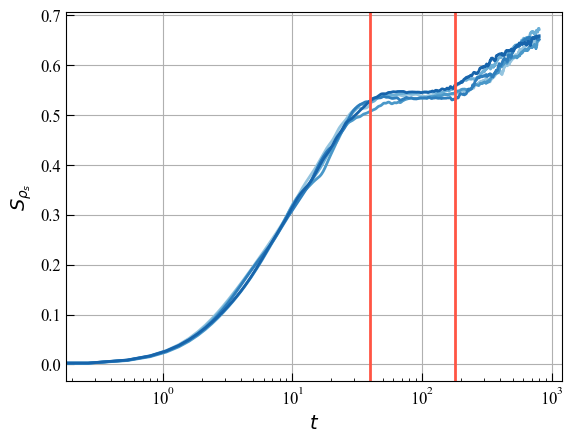

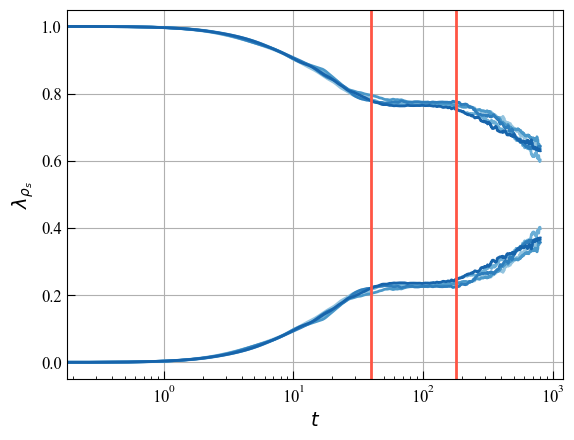

In [ ]:
name="general_decoherence"+"VN"+".pickle"
# Reopen the saved plot
with open(name, 'rb') as f:
    fig = pickle.load(f)

# Edit the plot (e.g., add vertical lines)
plt.figure(fig.number)  # Set the figure to the loaded one
plt.axvline(x=40, color='#ff5544', linestyle='-') 
plt.axvline(x=180, color='#ff5544', linestyle='-') 
plt.xscale('log')
# Show the modified plot
plt.show()

# Save the modified plot as a PNG image
modified_name = "general_decoherence" + "VN" + "_modified" + ".pdf"

fig.savefig(modified_name)  # Save the figure as a PNG file

name="general_decoherence"+"eigval"+".pickle"
# Reopen the saved plot
with open(name, 'rb') as f:
    fig = pickle.load(f)

# Edit the plot (e.g., add vertical lines)
plt.figure(fig.number)  # Set the figure to the loaded one
plt.axvline(x=40, color='#ff5544', linestyle='-') 
plt.axvline(x=180, color='#ff5544', linestyle='-') 
plt.ylabel(r'$\lambda_{\rho_s}$')
plt.xscale('log')
# Show the modified plot
plt.show()

# Save the modified plot as a PNG image
modified_name = "general_decoherence" + "eigval" + "_modified" + ".pdf"

fig.savefig(modified_name)  # Save the figure as a PNG file



IndexError: list index out of range

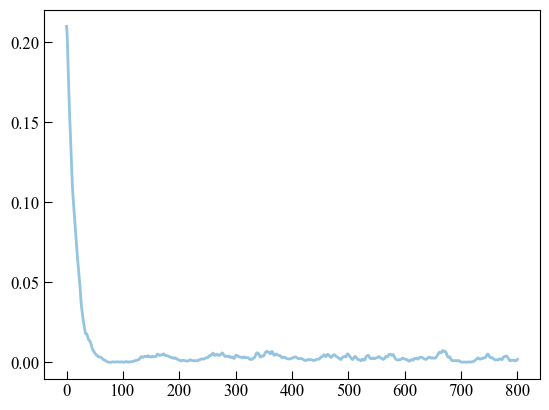

In [85]:
n_e=8
file_name="general_decoherence"
file_suffixes=[1,2]

plot_overlap(n_e,file_name,file_suffixes)

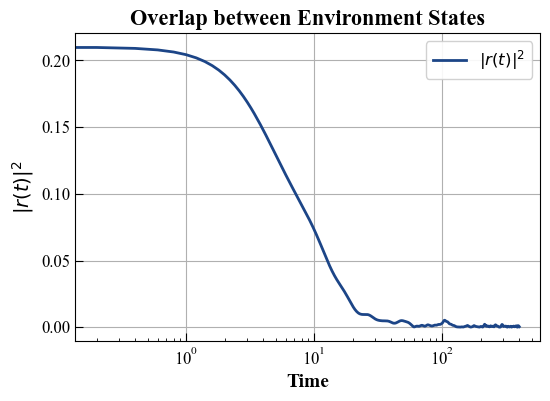

In [74]:
n_e=8
d_2=2**n_e
file_name="non_locality_long_long_2"
tmax, ind_nb, log = load_param(file_name)
result = load_result(file_name)
tlist = load_tlist(file_name)

plot_overlap(ind_nb,tlist, result,d_2)